In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [114]:
train_data, test_data = pd.read_csv('../data/class_train.csv'), pd.read_csv('../data/class_test.csv')
data = pd.concat([train_data, test_data], ignore_index = True)
data.head()

,Plasma renin activity,Aldosterone-to-renin ratio -more detailed ranges in Aldosterone/renin ratio article,Oxygen saturation,17α-Hydroxyprogesterone,Anti ds-DNA,Reticulocyte hemoglobin equivalent,Fibrinogen,Procalcitonin,SHBG -more detailed ranges in SHBG article,[H+],...,Luteinizing hormone (LH)-more detailed menstrual cycle ranges in separate diagram,Alpha 1-antitrypsin (AAT),Eosinophil cationic protein (ECP),Absolute content of carbon dioxide (CO2),Chloride (Cl),Amylase,IgM,Copper (Cu),Viscosity,Outcome
0,955.281824,6.008015,7.679162,8181.376094,637.176162,1655.935340,5572.232595,295.898724,8168.540684,1912.478041,...,9919.820568,4.764464,1911.290743,4.793836,7405.484356,10.522503,4644.152278,3.086409,7269.046415,0
1,1230.105982,16.004716,13.758903,10160.744348,826.173179,2005.291945,6645.645696,367.173919,9936.287732,2597.155427,...,12058.542281,21.412708,2225.412113,5.465201,8928.703718,20.770201,5900.118535,12.234226,8818.661328,0
2,1368.526126,3.397476,5.733414,11757.239383,963.221156,2309.067904,8208.582321,437.166464,11233.856279,2918.152097,...,14481.374431,5.024250,2828.177336,2.918513,10384.582517,1.224893,6798.340905,17.303987,10614.577165,0
3,1127.887803,6.128786,5.891781,9134.772017,737.518529,1859.595041,6469.579061,340.152779,9009.068421,2392.056388,...,10919.936385,1.362570,2130.646124,2.115228,8229.748093,2.486947,5371.300693,19.875223,8077.366728,0
4,1279.789838,11.834707,2.035606,10233.512908,836.776751,2064.653384,7036.941075,377.650340,10082.609454,2723.896231,...,12106.667363,13.604294,2284.807267,1.553677,9033.725105,0.833231,6061.031816,11.714379,8916.594576,0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Columns: 160 entries, Plasma renin activity to Outcome
dtypes: float64(157), int64(3)
memory usage: 145.1 KB


Som vi ser jämte 'dtypes' så har vi inga nan värden i datasetet

In [35]:
import numpy as np
import sklearn.decomposition

def do_pca(X, n_components = 128):
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    pca = sklearn.decomposition.PCA(n_components = n_components)
    principal_components = pca.fit_transform(X)
    return principal_components, pca

In [118]:
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def fit_and_process_data(df, clf , fix_imbalance = True, n_pc_components = None, beta = 1):
    # denna funktion är till för att lätt kunna välja olika preprocessing tekniker 
    # och se hur de påverkar resultatet.
    
    X = df.drop(columns = ['Outcome'])
    Y = df['Outcome']
    
    if fix_imbalance:
        sm = SMOTE(random_state=42)
        X, Y = sm.fit_resample(X, Y)
    
    if n_pc_components:
        X, _ = do_pca(X, n_components = n_pc_components)
    
    if clf == 'GBC':
        model = GradientBoostingClassifier(n_estimators=500, learning_rate=1,max_depth=1, random_state=0)
    elif clf == 'LOGREG':
        model = LogisticRegression(random_state=0)
        
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.3)
    model.fit(X_train, y_train)
        
    predictions = model.predict(X_test)
    
    if clf == 'GBC':
        feature_importance = model.feature_importances_
    else:
        feature_importance = None

    fb_score = fbeta_score(y_test, predictions, average='macro', beta=beta)
    f1_score_ = f1_score(y_test, predictions, average='macro')
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')

    result = {'X': X,
              'Y': Y,
              'x_train': X_train,
              'x_test': X_test, 
              'y_train': y_train,
              'y_test': y_test,
              'predictions': predictions,
              'f1_score': f1_score_,
              'beta': beta,
              "fbeta_score": fb_score,
              'model': model, 
              'precision': precision,
              'recall': recall,
              'feature_importance': feature_importance,
              'n_components': n_pc_components
             }
    return result


## Class imbalance

In [119]:
print(data['Outcome'].value_counts())

1    64
0    52
Name: Outcome, dtype: int64


Som vi ser så har vi en liten obalans i klasserna. Vi har 12 mer exempel från klass 1

## Logistic regression

In [ ]:
log_reg_result_imbalanced = fit_and_process_data(data, clf = 'LOGREG', fix_imbalance = False)
log_reg_result_fix_imbalance = fit_and_process_data(data, clf = 'LOGREG')

Score before fixing class imbalance:
f1score 0.6173254835996635

After fixing class imbalance:
f1score 0.6112956810631229


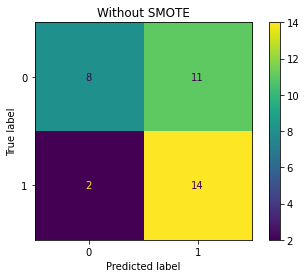

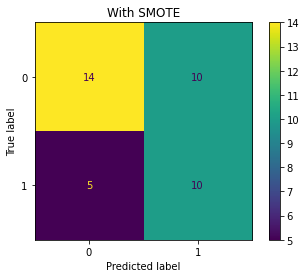

In [110]:
from sklearn.metrics import plot_confusion_matrix

print('Score before fixing class imbalance:\nf1score', log_reg_result_imbalanced['f1_score'])
print()
print('After fixing class imbalance:\nf1score', log_reg_result_fix_imbalance['f1_score'])

plot_confusion_matrix(log_reg_result_imbalanced['model'], log_reg_result_imbalanced['x_test'], log_reg_result_imbalanced['y_test'])
plt.title('Without SMOTE')
plt.grid(False)

plot_confusion_matrix(log_reg_result_fix_imbalance['model'], log_reg_result_fix_imbalance['x_test'], log_reg_result_fix_imbalance['y_test'])
plt.title('With SMOTE')
plt.grid(False)

## GradientBoostingClassifier

In [40]:
GBC_result_imbalanced = fit_and_process_data(data, clf = 'GBC', fix_imbalance = False)
GBC_result_fix_imbalance = fit_and_process_data(data, clf = 'GBC')

Score before fixing class imbalance:
f1score 0.5970394736842105

After fixing class imbalance:
f1score 0.7149501661129569


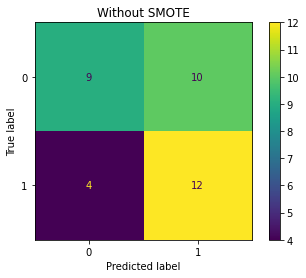

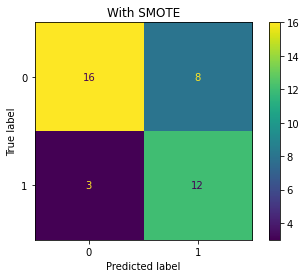

In [41]:
print('Score before fixing class imbalance:\nf1score', GBC_result_imbalanced['f1_score'])
print()
print('After fixing class imbalance:\nf1score', GBC_result_fix_imbalance['f1_score'])
plot_confusion_matrix(GBC_result_imbalanced['model'], GBC_result_imbalanced['x_test'], GBC_result_imbalanced['y_test'])
plt.title('Without SMOTE')
plt.grid(False)
plot_confusion_matrix(GBC_result_fix_imbalance['model'], GBC_result_fix_imbalance['x_test'], GBC_result_fix_imbalance['y_test'])
plt.title('With SMOTE')
plt.grid(False)

In [42]:
sm = SMOTE(random_state=42)
X, Y = sm.fit_resample(data.drop(columns = ['Outcome']), data['Outcome'])
data = pd.concat([pd.DataFrame(X, columns = data.drop(columns = ['Outcome']).columns), pd.DataFrame(Y)], axis = 1)

In [43]:
data

,Plasma renin activity,Aldosterone-to-renin ratio -more detailed ranges in Aldosterone/renin ratio article,Oxygen saturation,17α-Hydroxyprogesterone,Anti ds-DNA,Reticulocyte hemoglobin equivalent,Fibrinogen,Procalcitonin,SHBG -more detailed ranges in SHBG article,[H+],...,Luteinizing hormone (LH)-more detailed menstrual cycle ranges in separate diagram,Alpha 1-antitrypsin (AAT),Eosinophil cationic protein (ECP),Absolute content of carbon dioxide (CO2),Chloride (Cl),Amylase,IgM,Copper (Cu),Viscosity,Outcome
0,955.281824,6.008015,7.679162,8181.376094,637.176162,1655.935340,5572.232595,295.898724,8168.540684,1912.478041,...,9919.820568,4.764464,1911.290743,4.793836,7405.484356,10.522503,4644.152278,3.086409,7269.046415,0
1,1230.105982,16.004716,13.758903,10160.744348,826.173179,2005.291945,6645.645696,367.173919,9936.287732,2597.155427,...,12058.542281,21.412708,2225.412113,5.465201,8928.703718,20.770201,5900.118535,12.234226,8818.661328,0
2,1368.526126,3.397476,5.733414,11757.239383,963.221156,2309.067904,8208.582321,437.166464,11233.856279,2918.152097,...,14481.374431,5.024250,2828.177336,2.918513,10384.582517,1.224893,6798.340905,17.303987,10614.577165,0
3,1127.887803,6.128786,5.891781,9134.772017,737.518529,1859.595041,6469.579061,340.152779,9009.068421,2392.056388,...,10919.936385,1.362570,2130.646124,2.115228,8229.748093,2.486947,5371.300693,19.875223,8077.366728,0
4,1279.789838,11.834707,2.035606,10233.512908,836.776751,2064.653384,7036.941075,377.650340,10082.609454,2723.896231,...,12106.667363,13.604294,2284.807267,1.553677,9033.725105,0.833231,6061.031816,11.714379,8916.594576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,1261.768484,4.972566,0.897038,10404.139195,840.221596,2078.321945,7248.233929,387.854492,10138.785518,2663.594336,...,12360.001255,1.445159,2395.963298,10.222503,9481.237941,10.617637,6062.680685,8.031410,9086.479073,0
124,1411.588361,7.947410,3.173109,12323.967117,906.852283,2434.473826,8039.064345,419.997620,11616.671104,2754.737372,...,14862.916775,5.457917,2860.629384,6.057196,12087.123589,5.502411,6626.857417,8.963607,10824.067681,0
125,1401.606128,15.375763,5.565881,12455.740706,887.453757,2536.991430,8033.522448,413.680343,12180.499391,2756.486744,...,15350.062473,12.699347,3031.023230,5.904589,12164.049745,3.269728,6560.970757,5.639798,11319.273466,0
126,1716.781644,12.373950,12.690409,14854.046940,1102.981890,2933.406155,9525.450734,498.184480,13935.676362,3455.468390,...,18060.975316,7.080159,3454.827608,12.408969,14323.675892,19.620786,7992.712584,4.949075,13163.880287,0


In [44]:
print(data['Outcome'].value_counts())

0    64
1    64
Name: Outcome, dtype: int64


Nu har vi balanserad data med lika många samples från varje klass

## PCA

In [51]:
explained_variance_ratio_sum = [value + sum(explained_variance_ratio[:i]) for i, value in enumerate(explained_variance_ratio)]
list(zip(explained_variance_ratio_sum, [i+1 for i in range(len(explained_variance_ratio_sum))]))


[(0.6096175432234001, 1),
 (0.6313497796769955, 2),
 (0.6503399578401473, 3),
 (0.6673485457640768, 4),
 (0.6834234282031246, 5),
 (0.6986910337191048, 6),
 (0.7135594007234383, 7),
 (0.7273233357528252, 8),
 (0.741014622437313, 9),
 (0.7538765843289813, 10),
 (0.7658429261585034, 11),
 (0.7775583247897976, 12),
 (0.7887229442637204, 13),
 (0.7991272403125445, 14),
 (0.8092482285271224, 15),
 (0.8188091418301129, 16),
 (0.8282441843635034, 17),
 (0.8372678058799314, 18),
 (0.8457585928867308, 19),
 (0.8538738838246882, 20),
 (0.8617132211067232, 21),
 (0.8693812438413426, 22),
 (0.8768474126066746, 23),
 (0.8838220543580535, 24),
 (0.8906779051833307, 25),
 (0.8972122204858558, 26),
 (0.9033283548933667, 27),
 (0.9093881264607748, 28),
 (0.9153305222739121, 29),
 (0.9209542585752468, 30),
 (0.9265432847183288, 31),
 (0.9317648647188972, 32),
 (0.9366477636712406, 33),
 (0.9413340942871864, 34),
 (0.9456437438158727, 35),
 (0.9497753218594125, 36),
 (0.953810559077132, 37),
 (0.95776006

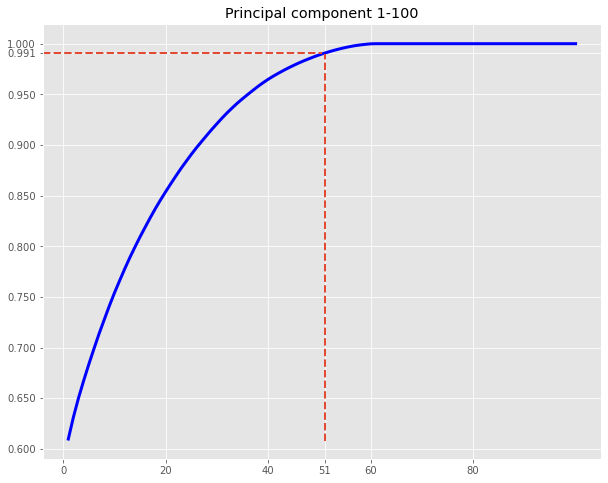

In [71]:
X = data.drop(columns = ['Outcome'])

principal_components, pca = do_pca(X)

explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio_sum = [value + sum(explained_variance_ratio[:i]) for i, value in enumerate(explained_variance_ratio)]

with plt.style.context('ggplot'):
    n_components = 100
    plt.figure(figsize = (10,8))
    plt.plot([i+1 for i in range(len(explained_variance_ratio_sum[:n_components]))], explained_variance_ratio_sum[:n_components], linewidth = 3, color = 'blue')
    plt.axhline(y=0.990662138349054, xmin = 0, xmax = 0.50, linestyle = '--', linewidth = 2)
    plt.axvline(x=51, ymin = 0.04, ymax = 0.93, linestyle = '--', linewidth = 2)

    y_ticks = list(np.arange(0.6, 1.05, step = 0.05))
    y_ticks.insert(8,round(0.990662138349054, 3))

    x_ticks = list(np.arange(0,100, step = 20))
    x_ticks.insert(3, 51)
    
    plt.yticks(y_ticks)
    plt.xticks(x_ticks)
    
    plt.title(f'Principal component 1-{n_components}')
    plt.show()


På plotten ovan så kan vi se att vi med 51 st pc's kan representera 99.1% av den ursprunliga variansen i datan. Så ingenting över detta kommer att tillföra mycket till modellen. 

In [89]:
# Kollar hur många pc som ger det bästa resultatet
pcas = [fit_and_process_data(data, clf = 'GBC', n_pc_components = n) for n in range(1,52)]

In [121]:
pca = fit_and_process_data(data, clf = 'GBC', n_pc_components = 4)
no_pca = fit_and_process_data(data, clf = 'GBC')

In [122]:
print('Without PCA (f1-score):', no_pca['f1_score'], '159 features')
print('With PCA (f1-score):', pca['f1_score'], f"{pca['n_components']} features")

Without PCA (f1-score): 0.7149501661129569 159 features
With PCA (f1-score): 0.7172050098879368 4 features


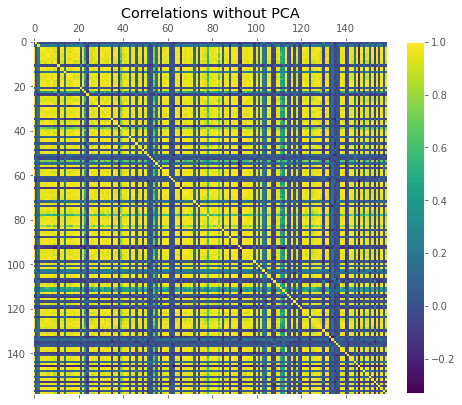

In [123]:
with plt.style.context('ggplot'):
    matfig = plt.figure(figsize=(7,7))
    plt.matshow(pd.DataFrame(no_pca['X']).corr(), fignum=matfig.number)
    plt.grid(False)
    plt.title('Correlations without PCA')
    plt.colorbar(fraction = 0.045)

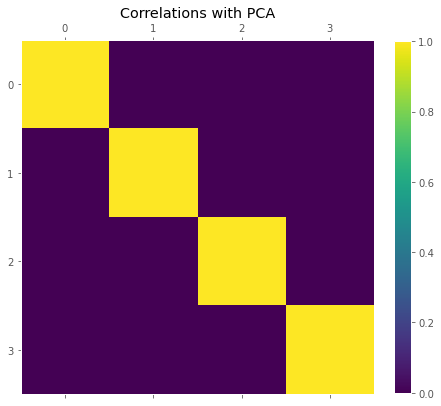

In [124]:
with plt.style.context('ggplot'):
    matfig = plt.figure(figsize=(7,7))
    plt.matshow(pd.DataFrame(pca['X']).corr(), fignum=matfig.number)
    plt.grid(False)
    plt.title('Correlations with PCA')
    plt.colorbar(fraction = 0.045)

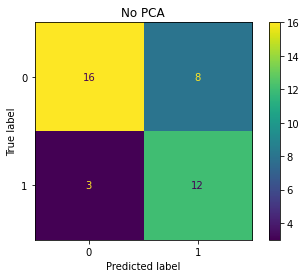

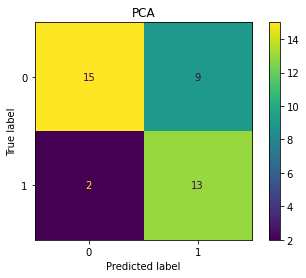

In [100]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(no_pca['model'], no_pca['x_test'], no_pca['y_test'])
plt.title('No PCA')
plt.grid(False)
plot_confusion_matrix(pca['model'], pca['x_test'], pca['y_test'])
plt.title('PCA')
plt.grid(False)

## Feature importance

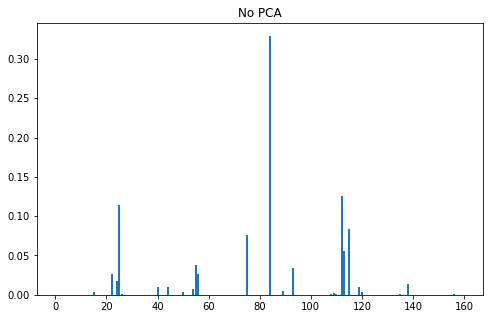

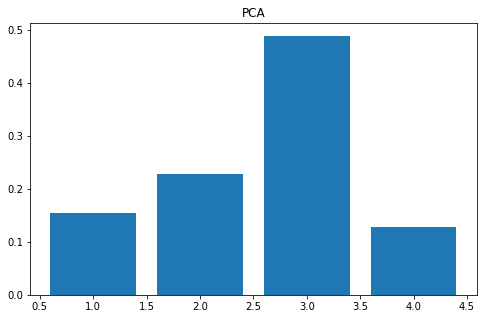

In [101]:
plt.figure(figsize=(8,5))
plt.title('No PCA')
plt.bar([i+1 for i in range(len(no_pca['feature_importance']))], no_pca['feature_importance'])
plt.show()

plt.figure(figsize=(8,5))
plt.title('PCA')
plt.bar([i+1 for i in range(len(pca['feature_importance']))], pca['feature_importance'])
plt.show()

Som vi ser så har vi med PCA inga onödiga features

# Final inference

In [102]:
def process_data(data, n_pc_components):
    X = data.drop(columns = ['Outcome'])
    Y = data['Outcome']
    
    # Fixa klass balans
    sm = SMOTE(random_state=42)
    X, Y = sm.fit_resample(X, Y)
    
    # Applicera pca
    X, _ = do_pca(X, n_pc_components)
    
    return X, Y

In [103]:
def train(X, Y, beta = 1):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state = 0, test_size = 0.2, shuffle = True)

    model = GradientBoostingClassifier(n_estimators=200, learning_rate=1, max_depth=2, random_state=0)
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    feature_importance = model.feature_importances_
    fb_score = fbeta_score(y_test, predictions, average='macro', beta=beta)
    
    f1_score_ = f1_score(y_test, predictions, average='macro')
    precision = precision_score(y_test, predictions, average='macro')
    recall = recall_score(y_test, predictions, average='macro')

    result = {'X': X,
              'Y': Y,
              'x_train': X_train,
              'x_test': X_test, 
              'y_train': y_train,
              'y_test': y_test,
              'predictions': predictions,
              'f1_score': f1_score_,
              'beta': beta,
              "fb_score": fb_score,
              'model': model, 
              'precision': precision,
              'recall': recall,
              'feature_importance': feature_importance,
             }
    return result

In [104]:
train_data, test_data = pd.read_csv('../data/class_train.csv'), pd.read_csv('../data/class_test.csv')
data = pd.concat([train_data, test_data], ignore_index = True)

X, Y = process_data(data, n_pc_components = 4)

In [126]:
# beta = 0.5

result = train(X,Y, beta = 0.5)
print(result['fb_score'])

0.7892777364110201


In [125]:
# beta = 1

result = train(X,Y, beta = 1)
print(result['fb_score'])

0.7678571428571428


In [127]:
# beta = 2

result = train(X,Y, beta = 2)
print(result['fb_score'])

0.7769066286528867
